# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# Задачи

Построить наулучшую модель для предсказания оттока клиентов по данному датасету. Критерии качества модели: F1-мера и AUC-ROC.

Провести сравнение между качеством моделей перед балансировкой классов и после.

# Импорт библиотек

In [1]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.metrics import f1_score, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

import scipy.stats as stats

import matplotlib.pyplot as plt

import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Подготовка данных

## Первичный осмотр

**Описание данных**

Признаки:
* RowNumber — индекс строки в данных
* CustomerId — уникальный идентификатор клиента
* Surname — фамилия
* CreditScore — кредитный рейтинг
* Geography — страна проживания
* Gender — пол
* Age — возраст
* Tenure — сколько лет человек является клиентом банка
* Balance — баланс на счёте
* NumOfProducts — количество продуктов банка, используемых клиентом
* HasCrCard — наличие кредитной карты
* IsActiveMember — активность клиента
* EstimatedSalary — предполагаемая зарплата

Целевой признак:
* Exited — факт ухода клиента

In [3]:
data = pd.read_csv('Churn.csv')
print(data.info())
display(data.describe().transpose())
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None


,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
CreditScore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
Age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
Tenure,9091.0,4.997690e+00,2.894723,0.00,2.00,5.000000e+00,7.000000e+00,10.00
Balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
NumOfProducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
HasCrCard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
IsActiveMember,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
EstimatedSalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


Сразу можно отметить несколько столбцов, которые в дальнейшем обучении модели будут бесполезны, а именно: **RowNumber**, **CustomerId** и **Surname**. Можно сразу их удалить.

In [4]:
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

---
Оставшиеся значения в пределах нормы, но стоит обратить внимание на отсутсующие значения в столбце **Tenure**, пропуски в котором наблюдаются у 10 % примеров.

In [5]:
data[data['Tenure'].isna()].head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0


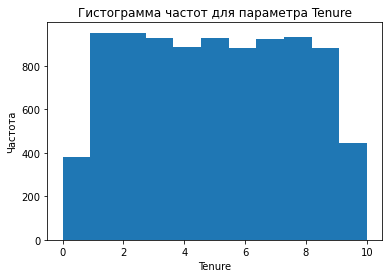

In [6]:
data['Tenure'].plot(kind='hist', bins=11)
plt.title('Гистограмма частот для параметра Tenure')
plt.xlabel('Tenure')
plt.ylabel('Частота')
plt.show()

Надежной замены для отсутсвующих значений в данном столбце нет. Значит наиболее разумной будет замена на случайное значение с добавлением метки о том, что это значение не является абсолютно истинным.

In [7]:
data['TenureWasNa'] = data['Tenure'].isna().astype('int64')
rng = np.random.default_rng(24) # Убедимся что случайные числа всегда идентичны
data['Tenure'] = data['Tenure'].fillna(
    pd.Series(
        rng.integers(0, 11, size=data['Tenure'].isna().sum()), index=data[data['Tenure'].isna()].index
    )
)

При проверке видно, что замена прошла успешно, а расперделение сильно внешне не поменялось:

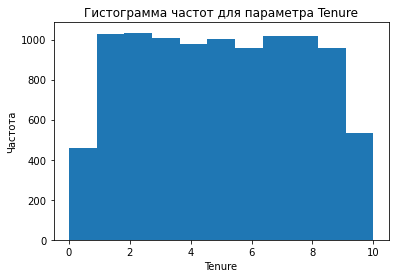

In [8]:
data['Tenure'].plot(kind='hist', bins=11)
plt.title('Гистограмма частот для параметра Tenure')
plt.xlabel('Tenure')
plt.ylabel('Частота')
plt.show()

In [9]:
display(data.head())
print('Количество оставшихся пустых значений =',data['Tenure'].isna().sum())

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,TenureWasNa
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1,0
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1,0
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0,0


Количество оставшихся пустых значений = 0


---
Теперь можно преобразовать оставшиеся категоральные признаки по технике OHE.

In [10]:
data = pd.get_dummies(data, drop_first=1)
data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,TenureWasNa,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,0,1,0


---
Необходимо разбить таблицу на обучающую и тестовую выборки. Так как в дальнейшем булет применяться кросс-валидация, валидационная выборка не потребуется.

In [11]:
features = data.drop(['Exited'], axis=1)
target = data['Exited']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=.2, random_state=24)
print(f'Размер обучающей выборки = {features_train.shape}, размер тестовой выборки = {features_test.shape}')

Размер обучающей выборки = (8000, 12), размер тестовой выборки = (2000, 12)


---
Теперь можно привести все признаки к одному масштабу.

In [12]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = pd.DataFrame(scaler.transform(features_train), columns=features_train.columns, index=features_train.index)
features_test = pd.DataFrame(scaler.transform(features_test), columns=features_train.columns, index=features_test.index)
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,TenureWasNa,Geography_Germany,Geography_Spain,Gender_Male
6604,1.278635,0.758090,-1.715264,0.295986,-0.914442,-1.540813,0.975549,-0.674262,3.165325,-0.578697,-0.569267,-1.098588
3203,0.708470,2.836051,-0.685720,-1.219089,0.798397,0.649008,0.975549,-0.728689,-0.315923,-0.578697,-0.569267,0.910259
2195,1.527435,1.797070,1.373369,-1.219089,0.798397,-1.540813,-1.025064,0.327406,-0.315923,-0.578697,1.756645,-1.098588
2576,-0.058661,-0.280891,-0.342538,-0.261098,0.798397,0.649008,-1.025064,-0.977633,-0.315923,-0.578697,1.756645,0.910259
4572,0.190138,-0.847607,0.687006,1.018151,-0.914442,0.649008,-1.025064,1.539484,-0.315923,1.728019,-0.569267,-1.098588


Категоральные признаки также проходят масштабирование. Отрицательного влияния на модели это не окажет.

Таблица готова к построению моделей.

# Исследование задачи

## Баланс классов

Клиенты делятся на 2 класса: те кто ушел из банка и те кто остались.

In [13]:
data['Exited'].value_counts(normalize=1)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

Соотношение тех кто остался к тем кто ушел составляет 4:1 соответсвенно. Пока что этот дисбаланс оставим без изменений.

## Перебор моделей

Оценка всех построенных моделей будет проводиться одинаково согласно функции search_scoring, которая выводит значение F1-меры для кросс-валидации и тестовой выборки, выводит лучшие гиперпараметры из случайного поиска, строит ROC-кривую и расчитывает площадь под ней для данной модели.

In [14]:
def search_scoring(search, features_test, graph_title):
    print('Лучшая F1-мера при кросс-валидации =', search.best_score_)
    print('Лучшие гиперпараметры:', search.best_params_)
    predicted = search.predict(features_test)
    probabilities = search.predict_proba(features_test)[:, 1]

    fpr, tpr, thresholds = roc_curve(target_test, probabilities)
    plt.figure(figsize=(8,8))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(str(graph_title))
    plt.show()

    print(f'F1-мера на тестовой выборке = {f1_score(target_test, predicted):.4}')
    print(f'Площадь под ROC-кривой = {roc_auc_score(target_test, probabilities):.4}')
    return None

### Логистическая регрессия

Лучшая F1-мера при кросс-валидации = 0.3095562516529319
Лучшие гиперпараметры: {'C': 121.51450019625558, 'penalty': 'l2', 'solver': 'lbfgs'}


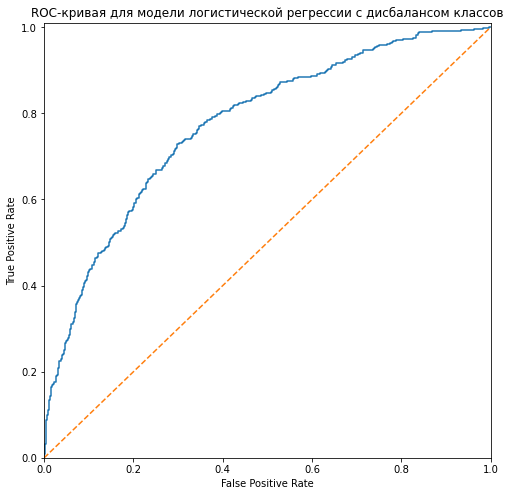

F1-мера на тестовой выборке = 0.2952
Площадь под ROC-кривой = 0.7735


In [15]:
model = LogisticRegression(random_state=24)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=24)

params = {}
params['solver'] = ['newton-cg', 'lbfgs', 'liblinear'] 
params['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
params['C'] = stats.loguniform(1e-5, 10000)

search = RandomizedSearchCV(model, params, n_iter=50, scoring='f1', n_jobs=-1, cv=cv, random_state=24)
search.fit(features_train, target_train)
search_scoring(search, features_test, 'ROC-кривая для модели логистической регрессии с дисбалансом классов')

### Случайный лес

Лучшая F1-мера при кросс-валидации = 0.5741938789251559
Лучшие гиперпараметры: {'bootstrap': False, 'max_depth': 43, 'min_samples_leaf': 0.0004864988011096544, 'min_samples_split': 0.0004290021013470081, 'n_estimators': 120}


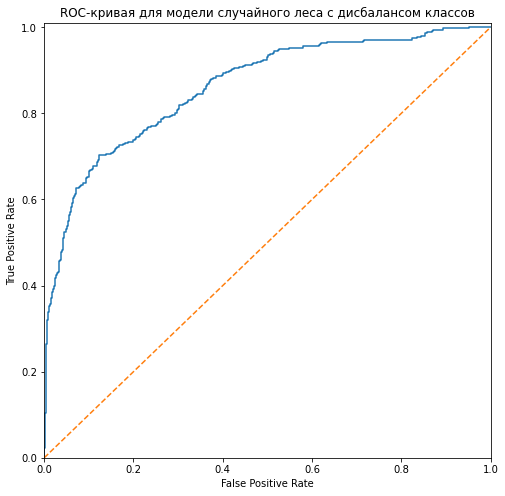

F1-мера на тестовой выборке = 0.5657
Площадь под ROC-кривой = 0.861


In [16]:
model = RandomForestClassifier(random_state=24)

params = {}
params['n_estimators'] = range(10, 201, 10)
params['max_depth'] = range(1, 51, 2)
params['min_samples_split'] = stats.loguniform(2e-4, 1e-1)
params['min_samples_leaf'] = stats.loguniform(2e-4, 1e-1)
params['bootstrap'] = [True, False]

search = RandomizedSearchCV(model, params, n_iter=50, scoring='f1', n_jobs=-1, cv=cv, random_state=24)
search.fit(features_train, target_train)

search_scoring(search, features_test, 'ROC-кривая для модели случайного леса с дисбалансом классов')

### K-ближайших соседей

Лучшая F1-мера при кросс-валидации = 0.4693695969142278
Лучшие гиперпараметры: {'weights': 'distance', 'n_neighbors': 4}


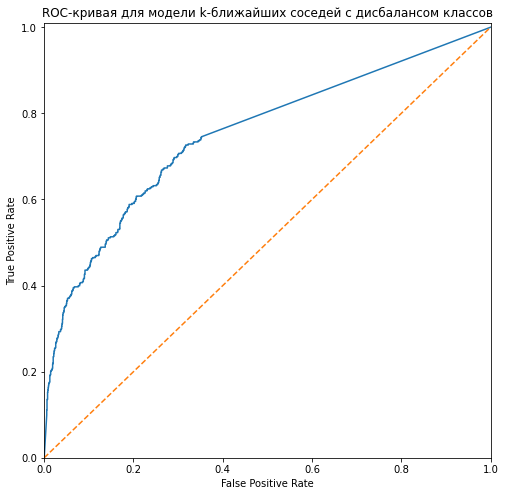

F1-мера на тестовой выборке = 0.4746
Площадь под ROC-кривой = 0.7512


In [17]:
model = KNeighborsClassifier()

params = {}
params['n_neighbors'] = range(2, 30)
params['weights'] = ['uniform', 'distance']

search = RandomizedSearchCV(model, params, n_iter=50, scoring='f1', n_jobs=-1, cv=cv, random_state=24)
search.fit(features_train, target_train)

search_scoring(search, features_test, 'ROC-кривая для модели k-ближайших соседей с дисбалансом классов')

## Вывод

Несбалансированные модели дали следующие рузультаты: 
* Логистическая регрессия: F1-мера на тестовой выборке = 0.2952, Площадь под ROC-кривой = 0.7735;
* Случайный лес: F1-мера на тестовой выборке = 0.5657, Площадь под ROC-кривой = 0.861;
* K-ближайших соседей: F1-мера на тестовой выборке = 0.4746, Площадь под ROC-кривой = 0.7512.

Интересно, что метод k-ближайших соседей дал AUC-ROC меньшее чем у логистической регрессии, однако F1-мера оказалось большей.

# Борьба с дисбалансом

## Балансировка весов классов

Балансировка весов будет проводиться встроенным в модель параметром.

### Логистическая регрессия

Лучшая F1-мера при кросс-валидации = 0.4878376724028215
Лучшие гиперпараметры: {'C': 0.041683649095317826, 'penalty': 'l2', 'solver': 'lbfgs'}


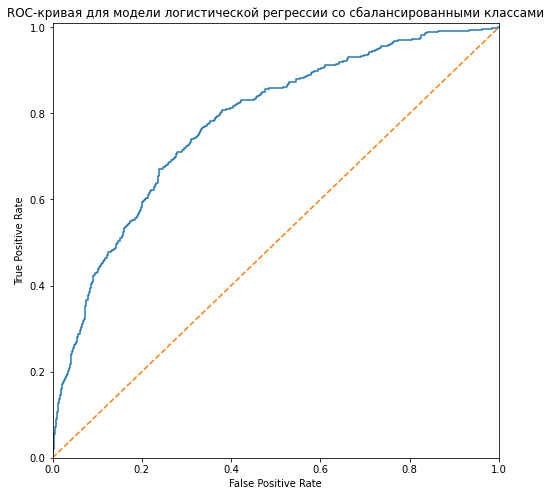

F1-мера на тестовой выборке = 0.5096
Площадь под ROC-кривой = 0.7775


In [18]:
model = LogisticRegression(random_state=24, class_weight='balanced')

params = {}
params['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
params['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
params['C'] = stats.loguniform(1e-5, 10000)

search = RandomizedSearchCV(model, params, n_iter=50, scoring='f1', n_jobs=-1, cv=cv, random_state=24)
search.fit(features_train, target_train)
search_scoring(search, features_test, 'ROC-кривая для модели логистической регрессии со сбалансированными классами')

### Случайный лес

Лучшая F1-мера при кросс-валидации = 0.6188007494570889
Лучшие гиперпараметры: {'bootstrap': True, 'max_depth': 27, 'min_samples_leaf': 0.0006443751729717477, 'min_samples_split': 0.0018930060498037454, 'n_estimators': 110}


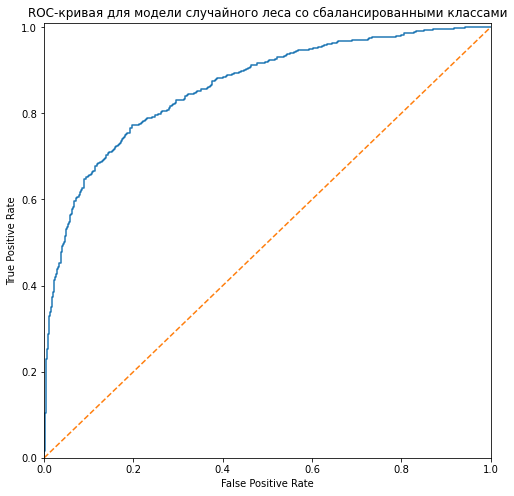

F1-мера на тестовой выборке = 0.6399
Площадь под ROC-кривой = 0.8622


In [19]:
model = RandomForestClassifier(random_state=24, class_weight='balanced')

params = {}
params['n_estimators'] = range(10, 201, 10)
params['max_depth'] = range(1, 51, 2)
params['min_samples_split'] = stats.loguniform(2e-4, 1e-1)
params['min_samples_leaf'] = stats.loguniform(2e-4, 1e-1)
params['bootstrap'] = [True, False]

search = RandomizedSearchCV(model, params, n_iter=50, scoring='f1', n_jobs=-1, cv=cv, random_state=24)
search.fit(features_train, target_train)

search_scoring(search, features_test, 'ROC-кривая для модели случайного леса со сбалансированными классами')

## Вывод

Сбалансированные по весам модели дали следующие рузультаты: 
* Логистическая регрессия: F1-мера на тестовой выборке = 0.5096, Площадь под ROC-кривой = 0.7775;
* Случайный лес: F1-мера на тестовой выборке = 0.6399, Площадь под ROC-кривой = 0.8622;
* K-ближайших соседей: не предполагает балансировки весов классов.

## Upsampling

Будет проводиться при помощи следующей функции:

In [20]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
        
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=24)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 3)

### Логистическая регрессия

Лучшая F1-мера при кросс-валидации = 0.6481320345141672
Лучшие гиперпараметры: {'C': 0.004048107173336376, 'penalty': 'l1', 'solver': 'liblinear'}


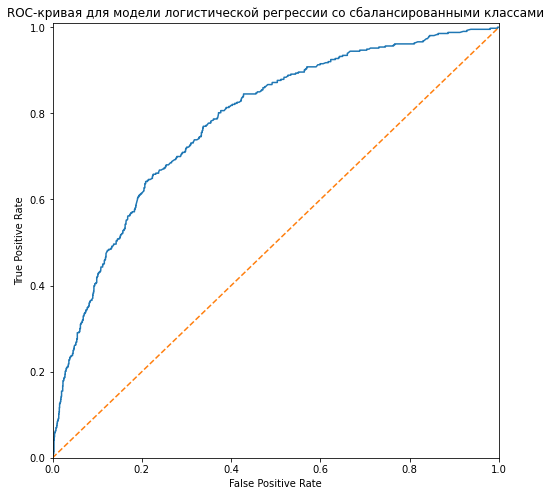

F1-мера на тестовой выборке = 0.5223
Площадь под ROC-кривой = 0.7813


In [21]:
model = LogisticRegression(random_state=24)

params = {}
params['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
params['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
params['C'] = stats.loguniform(1e-5, 10000)

search = RandomizedSearchCV(model, params, n_iter=50, scoring='f1', n_jobs=-1, cv=cv, random_state=24)
search.fit(features_upsampled, target_upsampled)
search_scoring(search, features_test, 'ROC-кривая для модели логистической регрессии со сбалансированными классами')

### Случайный лес

Лучшая F1-мера при кросс-валидации = 0.9047696856178536
Лучшие гиперпараметры: {'bootstrap': False, 'max_depth': 43, 'min_samples_leaf': 0.0004864988011096544, 'min_samples_split': 0.0004290021013470081, 'n_estimators': 120}


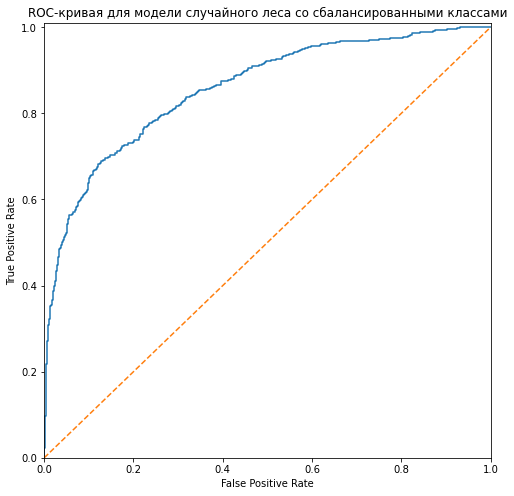

F1-мера на тестовой выборке = 0.6256
Площадь под ROC-кривой = 0.8572


In [22]:
model = RandomForestClassifier(random_state=24)

params = {}
params['n_estimators'] = range(10, 201, 10)
params['max_depth'] = range(1, 51, 2)
params['min_samples_split'] = stats.loguniform(2e-4, 1e-1)
params['min_samples_leaf'] = stats.loguniform(2e-4, 1e-1)
params['bootstrap'] = [True, False]

search = RandomizedSearchCV(model, params, n_iter=50, scoring='f1', n_jobs=-1, cv=cv, random_state=24)
search.fit(features_upsampled, target_upsampled)

search_scoring(search, features_test, 'ROC-кривая для модели случайного леса со сбалансированными классами')

### K-ближайших соседей

Лучшая F1-мера при кросс-валидации = 0.9148062840625907
Лучшие гиперпараметры: {'weights': 'distance', 'n_neighbors': 2}


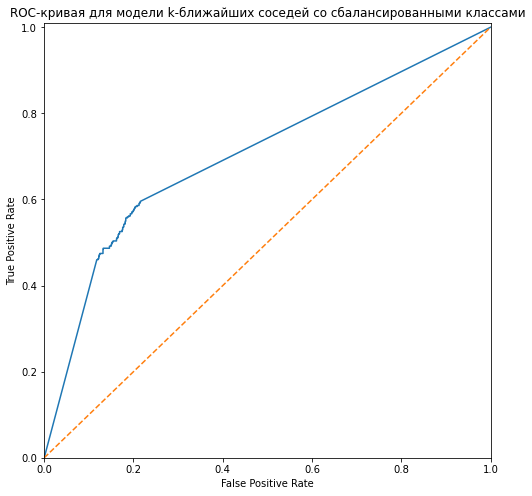

F1-мера на тестовой выборке = 0.481
Площадь под ROC-кривой = 0.7042


In [23]:
model = KNeighborsClassifier()

params = {}
params['n_neighbors'] = range(2, 30)
params['weights'] = ['uniform', 'distance']

search = RandomizedSearchCV(model, params, n_iter=50, scoring='f1', n_jobs=-1, cv=cv, random_state=24)
search.fit(features_upsampled, target_upsampled)

search_scoring(search, features_test, 'ROC-кривая для модели k-ближайших соседей со сбалансированными классами')

## Вывод

Сбалансированные с помощью upsampling модели дали следующие рузультаты: 
* Логистическая регрессия: F1-мера на тестовой выборке = 0.5223, Площадь под ROC-кривой = 0.7813;
* Случайный лес: F1-мера на тестовой выборке = 0.6256, Площадь под ROC-кривой = 0.8572;
* K-ближайших соседей: F1-мера на тестовой выборке = 0.481, Площадь под ROC-кривой = 0.7042.

Однако:
* Логистическая регрессия: Лучшая F1-мера при кросс-валидации = 0.6481320345141672
* Случайный лес: Лучшая F1-мера при кросс-валидации = 0.9047696856178536
* K-ближайших соседей: Лучшая F1-мера при кросс-валидации = 0.9148062840625907

из того что F1-меры для кросс-валидации значительно больше F1-мер на тестовых выборках следует, что в случае балансирования с помощью upsampling переобучение модели было значительно сильнее чем в предыдущих вариантах.

## Downsampling

Будет проводиться при помощи следующей функции:

In [24]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=24)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=24)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=24)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 1/3)

### Логистическая регрессия

Лучшая F1-мера при кросс-валидации = 0.6286878892108173
Лучшие гиперпараметры: {'C': 4366.723868659863}


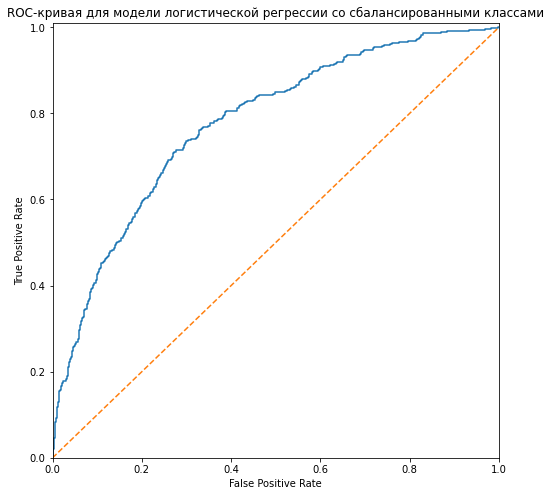

F1-мера на тестовой выборке = 0.5026
Площадь под ROC-кривой = 0.7761


In [25]:
model = LogisticRegression(random_state=24)

params = {}
# params['solver'] = ['newton-cg', 'lbfgs', 'liblinear'] 
# params['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
params['C'] = stats.loguniform(1e-5, 10000)

search = RandomizedSearchCV(model, params, n_iter=50, scoring='f1', n_jobs=-1, cv=cv, random_state=24)
search.fit(features_downsampled, target_downsampled)
search_scoring(search, features_test, 'ROC-кривая для модели логистической регрессии со сбалансированными классами')

### Случайный лес

Лучшая F1-мера при кросс-валидации = 0.7308983609673941
Лучшие гиперпараметры: {'bootstrap': True, 'max_depth': 27, 'min_samples_leaf': 0.0006443751729717477, 'min_samples_split': 0.0018930060498037454, 'n_estimators': 110}


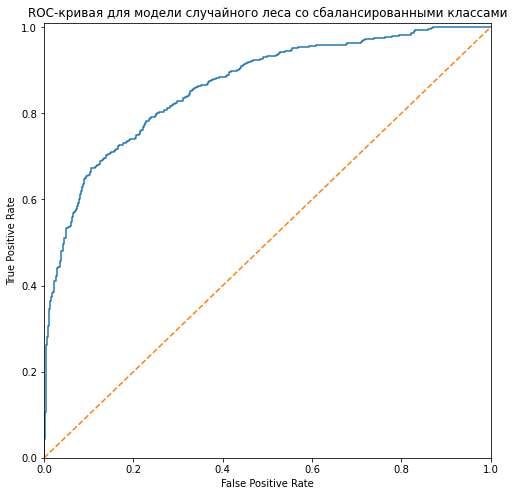

F1-мера на тестовой выборке = 0.6291
Площадь под ROC-кривой = 0.8631


In [26]:
model = RandomForestClassifier(random_state=24)

params = {}
params['n_estimators'] = range(10, 201, 10)
params['max_depth'] = range(1, 51, 2)
params['min_samples_split'] = stats.loguniform(2e-4, 1e-1)
params['min_samples_leaf'] = stats.loguniform(2e-4, 1e-1)
params['bootstrap'] = [True, False]

search = RandomizedSearchCV(model, params, n_iter=50, scoring='f1', n_jobs=-1, cv=cv, random_state=24)
search.fit(features_downsampled, target_downsampled)

search_scoring(search, features_test, 'ROC-кривая для модели случайного леса со сбалансированными классами')

### K-ближайших соседей

Лучшая F1-мера при кросс-валидации = 0.6723837859060559
Лучшие гиперпараметры: {'weights': 'distance', 'n_neighbors': 12}


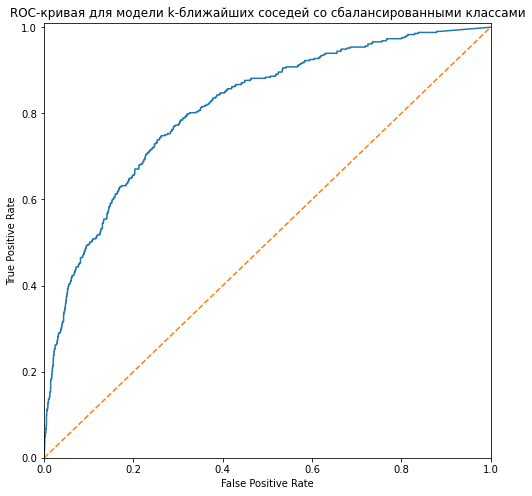

F1-мера на тестовой выборке = 0.5469
Площадь под ROC-кривой = 0.8118


In [27]:
model = KNeighborsClassifier()

params = {}
params['n_neighbors'] = range(2, 30)
params['weights'] = ['uniform', 'distance']

search = RandomizedSearchCV(model, params, n_iter=50, scoring='f1', n_jobs=-1, cv=cv, random_state=24)
search.fit(features_downsampled, target_downsampled)

search_scoring(search, features_test, 'ROC-кривая для модели k-ближайших соседей со сбалансированными классами')

## Вывод

Сбалансированные с помощью downsampling модели дали следующие рузультаты: 
* Логистическая регрессия: F1-мера на тестовой выборке = 0.5308, Площадь под ROC-кривой = 0.7808;
* Случайный лес: F1-мера на тестовой выборке = 0.6291, Площадь под ROC-кривой = 0.8631;
* K-ближайших соседей: F1-мера на тестовой выборке = 0.5469, Площадь под ROC-кривой = 0.8118.

В отличие от метода upsampling в downsampling переобучение не так сильно:
* Логистическая регрессия: Лучшая F1-мера при кросс-валидации = 0.6790603444238992;
* Случайный лес: Лучшая F1-мера при кросс-валидации = 0.7308983609673941;
* K-ближайших соседей: Лучшая F1-мера при кросс-валидации = 0.6723837859060559.

# Сравнение моделей

## Логистическая регрессия

Несбалансированная:
* F1-мера при кросс-валидации = 0.3095562516529319
* F1-мера на тестовой выборке = 0.2952;
* Площадь под ROC-кривой = 0.7735.

Class_weight='balanced':
* Лучшая F1-мера при кросс-валидации = 0.4878376724028215;
* F1-мера на тестовой выборке = 0.5096;
* Площадь под ROC-кривой = 0.7775.

Upsamle:
* Лучшая F1-мера при кросс-валидации = 0.6481320345141672;
* F1-мера на тестовой выборке = 0.5223;
* Площадь под ROC-кривой = 0.7813. **Наибольшая AUC-ROC**

Downsample:
* Лучшая F1-мера при кросс-валидации = 0.6790603444238992;
* F1-мера на тестовой выборке = 0.5308; **Наибольшая F1-мера**
* Площадь под ROC-кривой = 0.7808.

## Случайный лес

Несбалансированная:
* Лучшая F1-мера при кросс валидации = 0.5741938789251559;
* F1-мера на тестовой выборке = 0.5657;
* Площадь под ROC-кривой = 0.861.

Class_weight='balanced':
* Лучшая F1-мера при кросс-валидации = 0.6199709544589651;
* F1-мера на тестовой выборке = 0.6399; **Наибольшая F1-мера**
* Площадь под ROC-кривой = 0.8622.

Upsamle:
* Лучшая F1-мера при кросс-валидации = 0.9047696856178536;
* F1-мера на тестовой выборке = 0.6256; 
* Площадь под ROC-кривой = 0.8572. 

Downsample:
* Лучшая F1-мера при кросс-валидации = 0.7308983609673941;
* F1-мера на тестовой выборке = 0.6291;
* Площадь под ROC-кривой = 0.8631. **Наибольшая AUC-ROC**

## K-ближайших соседей

Лучшая F1-мера при кросс-валидации = 0.6188007494570889
Лучшие гиперпараметры: {'bootstrap': True, 'max_depth': 27, 'min_samples_leaf': 0.0006443751729717477, 'min_samples_split': 0.0018930060498037454, 'n_estimators': 110}

F1-мера на тестовой выборке = 0.6399
Площадь под ROC-кривой = 0.8622
Несбалансированная:
* Лучшая F1-мера при кросс-валидации = 0.4693695969142278;
* F1-мера на тестовой выборке = 0.4746;
* Площадь под ROC-кривой = 0.7512.

Class_weight='balanced':
* не предполагает балансировки весов классов.

Upsamle:
* Лучшая F1-мера при кросс-валидации = 0.9148062840625907;
* F1-мера на тестовой выборке = 0.481; **Наибольшая F1-мера**
* Площадь под ROC-кривой = 0.7042. 

Downsample:
* Лучшая F1-мера при кросс-валидации = 0.6723837859060559;
* F1-мера на тестовой выборке = 0.5469;
* Площадь под ROC-кривой = 0.8118. **Наибольшая AUC-ROC**

# Общий вывод

Лучшей моделью и по показателю F1-меры, и по AUC-ROC оказался случайный лес, для которого классы были сбалансированны по весам встроенным параметром class_weight.

Его результаты на тестовой выборке: F1-мера = 0.6399, Площадь под ROC-кривой = 0.8622.

Его гиперпараметры: {'bootstrap': True, 'max_depth': 27, 'min_samples_leaf': 0.0006443751729717477, 'min_samples_split': 0.0018930060498037454, 'n_estimators': 110}

Таким образом можно заключить что:
1. Балансировка классов любым из методов позволяет получить лучшие показатели митрик F1-меры и AUC-ROC для всех испытанных моделей.
2. Методы upsampling и downsampling дают немного меньший, но все же значительный прирост паказателей чем встроенный параметр модели class_weight='balanced'. И при этом способствуют переобучению модели.